# NLP Capstone

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')

In [2]:
from nltk.corpus import reuters

In [3]:
# We'll choose some categories at random and use those for the rest of our analysis.
np.random.seed(3)
categories = list(np.random.choice(reuters.categories(), 15, replace=False))
print(categories)

['tin', 'coffee', 'gold', 'yen', 'rubber', 'palm-oil', 'lin-oil', 'rape-oil', 'wheat', 'soy-oil', 'nickel', 'cocoa', 'sugar', 'nzdlr', 'sorghum']


In [4]:
# Let's check that our categories have relatively the same order of magnitude of articles associated with them.
[(len(reuters.fileids(x)), x) for x in categories]

[(30, 'tin'),
 (139, 'coffee'),
 (124, 'gold'),
 (59, 'yen'),
 (49, 'rubber'),
 (40, 'palm-oil'),
 (2, 'lin-oil'),
 (8, 'rape-oil'),
 (283, 'wheat'),
 (25, 'soy-oil'),
 (9, 'nickel'),
 (73, 'cocoa'),
 (162, 'sugar'),
 (4, 'nzdlr'),
 (34, 'sorghum')]

In [5]:
# Let's see how many articles as attached to those categories, the names of a few, and total word count.
print('Number of articles:', len(reuters.fileids(categories)))
fileids = reuters.fileids(categories)
print(fileids[:5])
print('Number of total words:', len(reuters.words(fileids)))

Number of articles: 962
['test/14832', 'test/14833', 'test/14840', 'test/14841', 'test/14842']
Number of total words: 227749


In [6]:
# We may also be pulling in a lot of other categories in this process because articles can have multiple associations.
# Let's see all the categories we're getting.
all_cats = reuters.categories(fileids)
cat_counts = [[len(set(reuters.fileids(x)).intersection(fileids)), x] for x in all_cats]
sorted(cat_counts, reverse=True)[:15]

[[311, 'grain'],
 [283, 'wheat'],
 [162, 'sugar'],
 [139, 'coffee'],
 [124, 'gold'],
 [104, 'corn'],
 [73, 'cocoa'],
 [68, 'oilseed'],
 [67, 'veg-oil'],
 [59, 'yen'],
 [56, 'money-fx'],
 [51, 'soybean'],
 [49, 'rubber'],
 [40, 'palm-oil'],
 [36, 'dlr']]

So, we've got a few common categories that we didn't choose explicitly, but which turned out to be popular across the articles that were selected. For instance, 'grain' wasn't in the initial list, but 'wheat' and 'sorghum' are both grains, so it is popular. 'Corn' and 'veg-oil' as well. This should be fine -- it means we may end up clustering by some of these more general categories, since it's unsupervised.

In [7]:
# These are the three ways we can look at each file.
print('Raw:\n', reuters.raw('test/14832'))
print('Words:\n', reuters.words('test/14832')[:])
print('\n\nCategories:\n', reuters.categories('test/14832'))

Raw:
 THAI TRADE DEFICIT WIDENS IN FIRST QUARTER
  Thailand's trade deficit widened to 4.5
  billion baht in the first quarter of 1987 from 2.1 billion a
  year ago, the Business Economics Department said.
      It said Janunary/March imports rose to 65.1 billion baht
  from 58.7 billion. Thailand's improved business climate this
  year resulted in a 27 pct increase in imports of raw materials
  and semi-finished products.
      The country's oil import bill, however, fell 23 pct in the
  first quarter due to lower oil prices.
      The department said first quarter exports expanded to 60.6
  billion baht from 56.6 billion.
      Export growth was smaller than expected due to lower
  earnings from many key commodities including rice whose
  earnings declined 18 pct, maize 66 pct, sugar 45 pct, tin 26
  pct and canned pineapples seven pct.
      Products registering high export growth were jewellery up
  64 pct, clothing 57 pct and rubber 35 pct.
  


Words:
 ['THAI', 'TRADE', 'DEFICIT'

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [9]:
# Create a list with each article as an element.
articles = [reuters.raw(x) for x in fileids]
articles[5]

'SUBROTO SAYS INDONESIA SUPPORTS TIN PACT EXTENSION\n  Mines and Energy Minister Subroto\n  confirmed Indonesian support for an extension of the sixth\n  International Tin Agreement (ITA), but said a new pact was not\n  necessary.\n      Asked by Reuters to clarify his statement on Monday in\n  which he said the pact should be allowed to lapse, Subroto said\n  Indonesia was ready to back extension of the ITA.\n      "We can support extension of the sixth agreement," he said.\n  "But a seventh accord we believe to be unnecessary."\n      The sixth ITA will expire at the end of June unless a\n  two-thirds majority of members vote for an extension.\n  \n\n'

## Tfidf

In [10]:
# Create the model, fit, and transform the original articles. Each article is one row.

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=7,
                             stop_words='english',
                             lowercase=True,
                             ngram_range=(1,2),
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True)

articles_tfidf = vectorizer.fit_transform(articles)
print('Number of Articles and Features:', articles_tfidf.get_shape())

Number of Articles and Features: (962, 3065)


In [24]:
# Split original articles, file ids, and Tfidf results into train and test.
X_train, X_test = train_test_split(articles, test_size=0.25, random_state=50)
fileids_train, fileids_test = train_test_split(fileids, test_size=0.25, random_state=50)
X_tfidf_train, X_tfidf_test = train_test_split(articles_tfidf, test_size=0.25, random_state=50)

# Make a version we can read.
X_tfidf_train_csr = X_tfidf_train.tocsr()

# Number of training articles
n = X_tfidf_train.get_shape()[0]

# A list of dictionaries, one per paragraph
tfidf_byarticle = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_tfidf_train_csr.nonzero()):
    tfidf_byarticle[i][terms[j]] = X_tfidf_train_csr[i, j]
    
print('Original Article:\n', X_train[5][:300], '...')
print('\n\nTfidf Vector:\n', tfidf_byarticle[5])
print('\n\nOriginal Categories:\n', reuters.categories(fileids_train[5]))

Original Article:
 TALKING POINT/GOLD
  The price of gold bullion and share
  prices of North American gold stocks are benefiting from
  continued weakness in the U.S. dollar, analysts said.
      "There's been a tug of war between the (currency)
  speculators and the central banks over the U.S. dollar and it
  looks  ...


Tfidf Vector:
 {'stock exchange': 0.068583855995053553, 'gained': 0.20575156798516064, 'lake': 0.064812098307609908, 'losing': 0.06594094959192659, 'funds': 0.05660248117540008, 'peak': 0.068583855995053553, 'break': 0.059656202422883192, 'talking': 0.067188836792021964, 'richard': 0.054176901492191426, 'implications': 0.067188836792021964, 'investors': 0.11430692605506962, 'points': 0.055571920695223022, 'uncertainty': 0.13188189918385318, 'gold silver': 0.058979219659812149, 'narrow': 0.063781537827432844, 'ratio': 0.061955781195155518, 'dlrs ounce': 0.12566702816984443, 'gold bullion': 0.067188836792021964, 'war': 0.13716771199010711, 'weakness': 0.06858385599505

In [12]:
# Build and fit our decomposition model. 
#We can alter the number of components until we're happy with our explained variance.
n_components = 100
svd = TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))

X_train_lsa = lsa.fit_transform(X_tfidf_train)

print('Variance explained with {} components:'.format(n_components), svd.explained_variance_ratio_.sum())

Variance explained with 100 components: 0.515201486448


In [13]:
# Make a Dataframe with articles as indices and components as features
articles_by_component=pd.DataFrame(X_train_lsa,index=X_train)
articles_by_component.shape

# Show the highest values for a few components, along with their articles
for i in range(2):
    print('Component {}:'.format(i))
    print(articles_by_component.loc[:,i].sort_values(ascending=False)[0:4])

Component 0:
EC DRIVING TO CAPTURE BRAZIL WHEAT MARKET - USDA\n  The European Community, EC, sold\n  75,000 tonnes of soft wheat at a subsidized price of between 85\n  and 89 dlrs per tonne FOB for March delivery in a continuing\n  bid to establish itself in the Brazilian wheat market, the U.S.\n  Agriculture Department said.\n      The sale sharply undercut the U.S. offer of 112 dlrs per\n  tonne FOB for 33,000 tonnes of wheat, it said in its latest\n  report on Export Markets for U.S grains.\n      EC sales to Brazil total about 225,000 tonnes during\n  1986/87 (July-June) in stark contrast to only 50,000 tonnes in\n  the 1985/86 season, it said.\n      The increasing presence of EC wheat in Brazil comes at a\n  time when the Brazilian Wheat Board, BWB, expects the wheat\n  import market will expand to 3.4 mln tonnes from the current\n  forecast of 3.0 mln in the 1986/87 year.\n      The BWB cites record consumption and an eventual decline in\n  domestic production, and says governme

That's cool, but it would be easier to see how we're doing if we looked at the 'Category' labels provided rather than the full text.

In [14]:
# Make a list of the categories for each article
categories_train = [reuters.categories(x) for x in fileids_train]

# Make a Dataframe with categories as indices and components as features
categories_by_component=pd.DataFrame(X_train_lsa,index=[str(x) for x in categories_train])
categories_by_component.shape

# Show the highest values for a few components, along with their categories
for i in range(8):
    print('Component {}:'.format(i))
    print(categories_by_component.loc[:,i].sort_values(ascending=False)[0:8])

Component 0:
['grain', 'wheat']                                                                  0.675786
['sugar']                                                                           0.641775
['grain', 'wheat']                                                                  0.637869
['sugar']                                                                           0.627297
['grain', 'wheat']                                                                  0.613011
['corn', 'grain', 'oilseed', 'palm-oil', 'rapeseed', 'ship', 'soy-oil', 'wheat']    0.588676
['corn', 'grain', 'wheat']                                                          0.583956
['sugar']                                                                           0.576889
Name: 0, dtype: float64
Component 1:
['cocoa']     0.655100
['cocoa']     0.631082
['cocoa']     0.624273
['cocoa']     0.620598
['coffee']    0.608240
['cocoa']     0.607381
['cocoa']     0.606527
['coffee']    0.605462
Name: 1, dtype: float6

This is really cool. Note that we've used the raw text from the articles to sort into components, not the categories themselves -- we're just using the category labels provided to act as a check on how we're doing. Looks like we've got:
    - Component 0: grains/sugars (maybe some hidden dependency, like selling or buying?)
    - Component 1: cocoa/coffee
    - Component 2: gold and silver
    - Component 3: cocoa
    - Component 4: sugar
    - Component 5: wheat
    - Component 6: yen
    - Component 7: plant oils
    

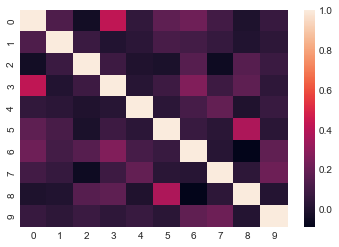

In [53]:
# Let's compute a similarity matrix and see which articles are most similar to each other.
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
sim_mat = pd.DataFrame(similarity).iloc[0:10, 0:10]
sim_full = pd.DataFrame(similarity)
sns.heatmap(sim_mat, yticklabels=range(sim_mat.shape[1]))
plt.show()

In [38]:
# These two should be fairly similar.
print(X_train[0], X_train[3])

ARGENTINA-BRAZIL TRADE JUMPED 90 PCT IN 1986
  Trade between Argentina and Brazil
  jumped 90 pct in 1986 versus 1985, Foreign Minister Dante
  Caputo said.
      Speaking to reporters, Caputo said the near doubling in
  trade showed the "tangible and immediate results" of a wide-
  ranging economic integration accord signed by the presidents of
  both countries last July.
      He said trade last year totalled 1.3 billion dlrs versus
  700 mln dlrs in 1985.
      The accord provided for capital goods trade between the two
  countries to rise to 2.0 billion dlrs over four years.
      Argentine wheat exports to Brazil will increase from
  1,375,000 tonnes in 1987 to 2.0 mln tonnes in 1991, the accord
  said.
  

 JAPAN DENIES PLANS TO CUT DUTIES ON CHOCOLATE
  Agriculture Ministry officials said they
  are not considering cuts in import duties on chocolate to help
  ease friction with the United States over agricultural trade.
      Japan has already lowered the duties sharply and we m

It looks like the similarities are: they both have to do with trade, they both involve 1985 and 1986, and they both talk about billions of dollars. Let's see what some of the *most* similar pairs are in the matrix.

In [69]:
# Remove the 1's from the diagonal and find the remaining max index.
print((sim_full - np.identity(len(sim_full))).idxmax()[:10])

0    710
1    256
2    674
3    147
4    683
5    712
6    469
7    653
8    649
9     95
dtype: int64


In [72]:
print(sim_full.iloc[1, 256])
print(X_train[1], X_train[256])

0.74375698455
AROUND 3.5 MLN ACRES SAID TO BE IDLED BY 0/92
  A 0/92 program would have very
  little impact on U.S. acreage, prompting farmers to idle only
  an additional 3.5 mln acres of cropland every year, according
  to a report from the Agriculture Department.
      The savings resulting from the additional 3.5 mln acres
  idled would be a little over 400 mln dlrs in loan savings, 35
  mln dlrs in transportation and storage savings, and 10-20 mln
  dlrs per year in deficiency payment savings, the report said.
      The USDA report asssessed the impacts of the proposed 0/92
  acreage program for wheat, corn, cotton, sorghum and barley.
  Last year, almost 245 mln acres of those crops were harvested.
      "The likelihood that the 0-92 provisiion will cause very
  large acreages to be removed from crop production is quite
  small," the report said.
      "The returns on typical farms still favor participation in
  the usual acreage reduction programs and seeding the permitted
  ac

## Bag of Words

For BoW, we'll have to clean each article and count words.

In [76]:
articles[:2]

["THAI TRADE DEFICIT WIDENS IN FIRST QUARTER\n  Thailand's trade deficit widened to 4.5\n  billion baht in the first quarter of 1987 from 2.1 billion a\n  year ago, the Business Economics Department said.\n      It said Janunary/March imports rose to 65.1 billion baht\n  from 58.7 billion. Thailand's improved business climate this\n  year resulted in a 27 pct increase in imports of raw materials\n  and semi-finished products.\n      The country's oil import bill, however, fell 23 pct in the\n  first quarter due to lower oil prices.\n      The department said first quarter exports expanded to 60.6\n  billion baht from 56.6 billion.\n      Export growth was smaller than expected due to lower\n  earnings from many key commodities including rice whose\n  earnings declined 18 pct, maize 66 pct, sugar 45 pct, tin 26\n  pct and canned pineapples seven pct.\n      Products registering high export growth were jewellery up\n  64 pct, clothing 57 pct and rubber 35 pct.\n  \n\n",
 "INDONESIA SEES 

In [78]:
import spacy
from collections import Counter

nlp = spacy.load('en')

In [87]:
# Simply splitting and joining will remove whitespace.
' '.join(articles[0].split()).lower()

"thai trade deficit widens in first quarter thailand's trade deficit widened to 4.5 billion baht in the first quarter of 1987 from 2.1 billion a year ago, the business economics department said. it said janunary/march imports rose to 65.1 billion baht from 58.7 billion. thailand's improved business climate this year resulted in a 27 pct increase in imports of raw materials and semi-finished products. the country's oil import bill, however, fell 23 pct in the first quarter due to lower oil prices. the department said first quarter exports expanded to 60.6 billion baht from 56.6 billion. export growth was smaller than expected due to lower earnings from many key commodities including rice whose earnings declined 18 pct, maize 66 pct, sugar 45 pct, tin 26 pct and canned pineapples seven pct. products registering high export growth were jewellery up 64 pct, clothing 57 pct and rubber 35 pct."

In [89]:
# Do it for all the articles.
art_clean = [' '.join(x.split()).lower() for x in articles]
art_clean[5]

'subroto says indonesia supports tin pact extension mines and energy minister subroto confirmed indonesian support for an extension of the sixth international tin agreement (ita), but said a new pact was not necessary. asked by reuters to clarify his statement on monday in which he said the pact should be allowed to lapse, subroto said indonesia was ready to back extension of the ita. "we can support extension of the sixth agreement," he said. "but a seventh accord we believe to be unnecessary." the sixth ita will expire at the end of june unless a two-thirds majority of members vote for an extension.'

In [93]:
art_doc = [nlp(x) for x in art_clean]

In [104]:
[x.lemma_ for x in art_doc]

AttributeError: 'spacy.tokens.doc.Doc' object has no attribute 'lemma_'